# Imports

In [59]:
import os
import json
from typing import Dict, List
import requests
import pandas as pd 
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords


from requests import get

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from env import github_token
from env import github_username

import acquire_titanic
import prep

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Acquiring our data

__Realized we need to exclude samples with no actual readme's, as it prevented our models from functioning.__

In [64]:
df = acquire_titanic.scrape_github_data()
df = df[df.readme_contents != 'error: no README']


# Preparing our data

In [4]:
df = prep.prep_articles(df)


## What did we end up with?

In [5]:
df.language.value_counts(dropna=False)

Jupyter Notebook    74
Python              35
R                   15
NaN                 10
HTML                 9
JavaScript           6
Scala                4
Java                 3
F#                   2
OpenEdge ABL         1
C                    1
Processing           1
C++                  1
Rust                 1
Clojure              1
PHP                  1
Name: language, dtype: int64

# Making a happy little dataframe

In [65]:
breakouts = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
breakouts.columns = ['n', 'percent']
breakouts

,n,percent
Jupyter Notebook,74,0.477419
Python,35,0.225806
R,15,0.096774
HTML,9,0.058065
JavaScript,6,0.038710
Scala,4,0.025806
Java,3,0.019355
F#,2,0.012903
OpenEdge ABL,1,0.006452
C,1,0.006452


__As a theoretical baseline, if the model only predicted Jupyter Notebook or not Jupyter Notebook, it would be correct 47% of the time.__

## Getting rid of undesired columns

In [66]:
easy_df = df.drop(columns =(['repo', 'original', 'stemmed', 'lemmatized']))
#easy_df

KeyError: "['original' 'stemmed' 'lemmatized'] not found in axis"

## Creating text by language

In [9]:
all_text = " ".join(easy_df.clean)
all_text = all_text.split()
all_text_counts = pd.Series(all_text).value_counts()

jupyter_text = " ".join(easy_df[easy_df.language == "Jupyter Notebook"].clean)
jupyter_text = jupyter_text.split()
jupyter_text_counts = pd.Series(jupyter_text).value_counts()

python_text = " ".join(easy_df[easy_df.language == "Python"].clean)
python_text = python_text.split()
python_text_counts = pd.Series(python_text).value_counts()

r_text = " ".join(easy_df[easy_df.language == "R"].clean)
r_text = r_text.split()
r_text_counts = pd.Series(r_text).value_counts()

html_text = " ".join(easy_df[easy_df.language == "HTML"].clean)
html_text = html_text.split()
html_text_counts = pd.Series(html_text).value_counts()

javascript_text = " ".join(easy_df[easy_df.language == "JavaScript"].clean)
javascript_text = javascript_text.split()
javascript_text_counts = pd.Series(javascript_text).value_counts()

java_text = " ".join(easy_df[easy_df.language == "Java"].clean)
java_text = java_text.split()
java_text_counts = pd.Series(java_text).value_counts()

scala_text = " ".join(easy_df[easy_df.language == "Scala"].clean)
scala_text = scala_text.split()
scala_text_counts = pd.Series(scala_text).value_counts()

fsharp_text = " ".join(easy_df[easy_df.language == "F#"].clean)
fsharp_text = fsharp_text.split()
fsharp_text_counts = pd.Series(fsharp_text).value_counts()

rust_text = " ".join(easy_df[easy_df.language == "Rust"].clean)
rust_text = rust_text.split()
rust_text_counts = pd.Series(rust_text).value_counts()

clojure_text = " ".join(easy_df[easy_df.language == "Clojure"].clean)
clojure_text = clojure_text.split()
clojure_text_counts = pd.Series(clojure_text).value_counts()

processing_text = " ".join(easy_df[easy_df.language == "Processing"].clean)
processing_text = processing_text.split()
processing_text_counts = pd.Series(processing_text).value_counts()

php_text = " ".join(easy_df[easy_df.language == "PHP"].clean)
php_text = php_text.split()
php_text_counts = pd.Series(php_text).value_counts()


c_text = " ".join(easy_df[easy_df.language == "C"].clean)
c_text = c_text.split()
c_text_counts = pd.Series(c_text).value_counts()

openedge_text = " ".join(easy_df[easy_df.language == "OpenEdge ABL"].clean)
openedge = openedge_text.split()
openedge_text_counts = pd.Series(openedge_text).value_counts()


cplus_text = " ".join(easy_df[easy_df.language == "C++"].clean)
cplus_text = cplus_text.split()
cplus_text_counts = pd.Series(cplus_text).value_counts()




### Dateframe that looks at word counts based on language

In [10]:
word_counts = (pd.concat([all_text_counts, jupyter_text_counts, python_text_counts, r_text_counts, html_text_counts, javascript_text_counts, java_text_counts, scala_text_counts, fsharp_text_counts, rust_text_counts, clojure_text_counts, processing_text_counts, php_text_counts, c_text_counts, openedge_text_counts, cplus_text_counts], axis=1, sort=True)
                .set_axis(['all', 'jupyter', 'python', 'r', 'html', 'javascript', 'java', 'scala', 'fsharp', 'rust', 'clojure', 'processing', 'php', 'c', 'openedge', 'cplus'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts

,all,jupyter,python,r,html,javascript,java,scala,fsharp,rust,clojure,processing,php,c,openedge,cplus
0000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
0000048,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00001,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000010001,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0001,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0001115,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0006316,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0006750,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
001,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
005,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Sorted word counts

In [67]:
word_counts.sort_values(by='all', ascending=False
                       ).head(10)



,all,jupyter,python,r,html,javascript,java,scala,fsharp,rust,clojure,processing,php,c,openedge,cplus
tr,884,884,0,0,0,0,0,0,0,0,0,0,0,0,0,0
td0td,658,658,0,0,0,0,0,0,0,0,0,0,0,0,0,0
td1td,383,383,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,224,193,14,5,4,1,1,2,0,0,0,0,0,0,0,0
tbody,160,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nonnull,140,114,26,0,0,0,0,0,0,0,0,0,0,0,0,0
td3td,137,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0
using,135,73,25,12,4,2,2,9,0,0,0,1,0,0,0,1
test,132,113,6,9,1,0,1,2,0,0,0,0,0,0,0,0
2,130,104,12,5,3,1,1,2,0,0,0,0,0,0,0,0


### Tried to examine if there were any unique words that might provide value to the model

In [12]:
pd.concat([word_counts[word_counts.jupyter == 0].sort_values(by='jupyter').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
          word_counts[word_counts.r == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.html == 0].sort_values(by='html').tail(6),
           word_counts[word_counts.javascript == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.java == 0].sort_values(by='java').tail(6),
          word_counts[word_counts.scala == 0].sort_values(by='scala').tail(6),
           word_counts[word_counts.fsharp == 0].sort_values(by='fsharp').tail(6),
           word_counts[word_counts.rust == 0].sort_values(by='rust').tail(6),
           word_counts[word_counts.clojure == 0].sort_values(by='clojure').tail(6),
           word_counts[word_counts.processing == 0].sort_values(by='processing').tail(6),
           word_counts[word_counts.php == 0].sort_values(by='php').tail(6),
           word_counts[word_counts.c == 0].sort_values(by='c').tail(6),
           word_counts[word_counts.openedge == 0].sort_values(by='openedge').tail(6),
           word_counts[word_counts.cplus == 0].sort_values(by='cplus').tail(6),])

,all,jupyter,python,r,html,javascript,java,scala,fsharp,rust,clojure,processing,php,c,openedge,cplus
flake8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
flag,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
five,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
fiturx1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
generic,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
zoom,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
fractional,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fraction,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fractextmisclassificationsttextobservationst,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fracbarxmufracs,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Bigrams

__Zach, if you're reading this, you're probably getting mad, maybe even irate, at the absence of a looping function. My bad. (CMD + C) & (CMD + V) still remain the fundamentals tools of my trade.__

In [14]:
top_20_text_bigrams = (pd.Series(nltk.ngrams(all_text, 2))
                      .value_counts()
                      .head(20))

top_20_jupyter_bigrams = (pd.Series(nltk.ngrams(jupyter_text, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams = (pd.Series(nltk.ngrams(python_text, 2))
                      .value_counts()
                      .head(20))

top_20_r_bigrams = (pd.Series(nltk.ngrams(r_text, 2))
                      .value_counts()
                      .head(20))

top_20_html_bigrams = (pd.Series(nltk.ngrams(html_text, 2))
                      .value_counts()
                      .head(20))



top_20_javascript_bigrams = (pd.Series(nltk.ngrams(javascript_text, 2))
                      .value_counts()
                      .head(20))

top_20_java_bigrams = (pd.Series(nltk.ngrams(java_text, 2))
                      .value_counts()
                      .head(20))

top_20_scala_bigrams = (pd.Series(nltk.ngrams(scala_text, 2))
                      .value_counts()
                      .head(20))

top_20_fsharp_bigrams = (pd.Series(nltk.ngrams(fsharp_text, 2))
                      .value_counts()
                      .head(20))



top_20_rust_bigrams = (pd.Series(nltk.ngrams(rust_text, 2))
                      .value_counts()
                      .head(20))

top_20_clojure_bigrams = (pd.Series(nltk.ngrams(clojure_text, 2))
                      .value_counts()
                      .head(20))
top_20_processing_bigrams = (pd.Series(nltk.ngrams(processing_text, 2))
                      .value_counts()
                      .head(20))

top_20_php_bigrams = (pd.Series(nltk.ngrams(php_text, 2))
                      .value_counts()
                      .head(20))



top_20_c_bigrams = (pd.Series(nltk.ngrams(c_text, 2))
                      .value_counts()
                      .head(20))

top_20_openedge_bigrams = (pd.Series(nltk.ngrams(openedge_text, 2))
                      .value_counts()
                      .head(20))

top_20_cplus_bigrams = (pd.Series(nltk.ngrams(cplus_text, 2))
                      .value_counts()
                      .head(20))

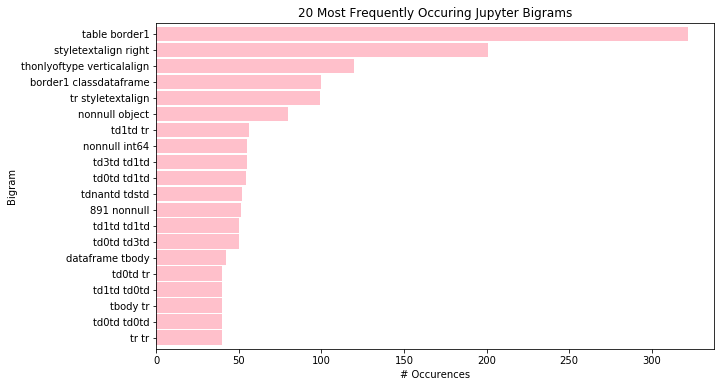

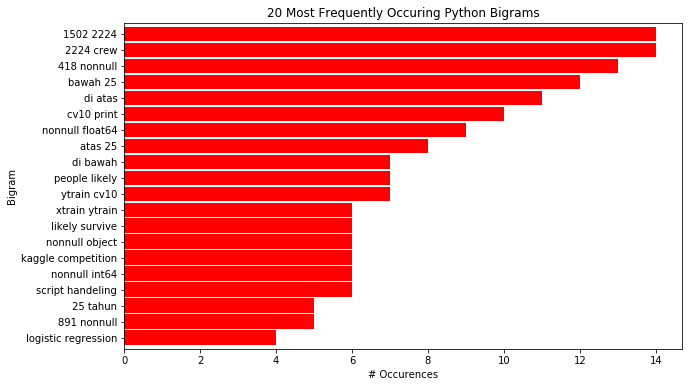

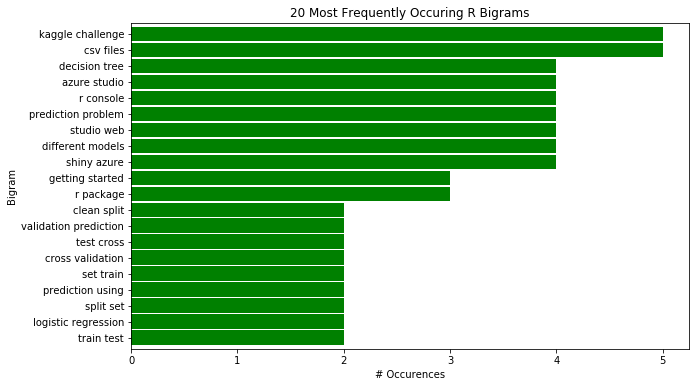

In [68]:
top_20_jupyter_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring Jupyter Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_jupyter_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_python_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring Python Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

top_20_r_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring R Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_r_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.show()

# WordCloud Time!!!!

(-0.5, 399.5, 999.5, -0.5)

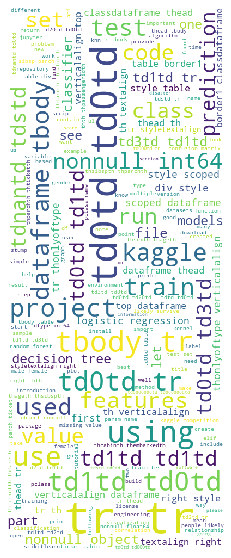

In [17]:
plt.figure(figsize=(10, 10))

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_text))

plt.imshow(all_cloud)
plt.axis('off')



(-0.5, 799.5, 599.5, -0.5)

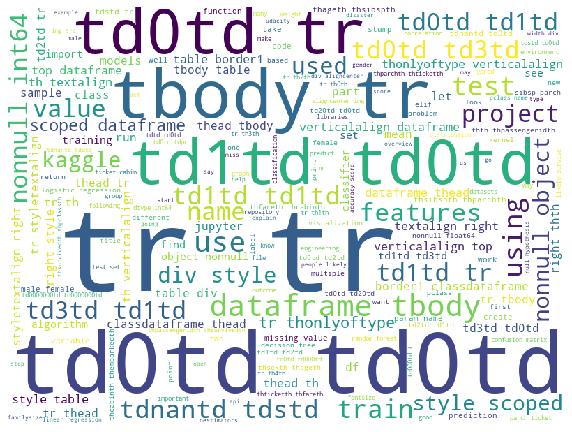

In [18]:
plt.figure(figsize=(10, 10))
jupyter_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(jupyter_text))
plt.imshow(jupyter_cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

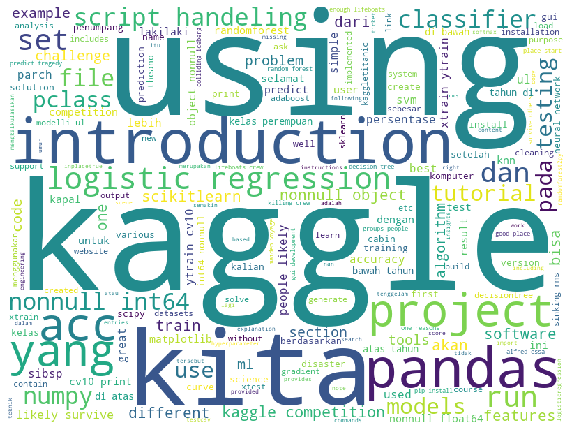

In [19]:
plt.figure(figsize=(10, 10))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_text))
plt.imshow(python_cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

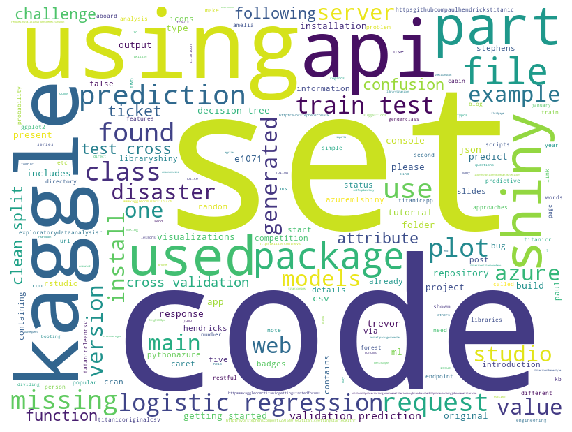

In [20]:
plt.figure(figsize=(10, 10))
r_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(r_text))
plt.imshow(r_cloud)
plt.axis('off')

## MODELING


__Vectorize!!__

In [21]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

__We cannot split data that has a value of 1, so we'll drop them from the dataframe.__

In [22]:
# drop where language == None
easy_df = easy_df[easy_df.language.isna() == False]

In [25]:
value_counts_df = pd.DataFrame(easy_df.language.value_counts(dropna = False))
one_doc_langs = list(value_counts_df[value_counts_df.language < 2].index)
for x in one_doc_langs:
    easy_df = easy_df[easy_df.language != x]

In [26]:
X = tfidf.fit_transform(easy_df.clean)
y= easy_df.language
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = .3)

In [27]:
train = pd.DataFrame(dict(acutal = y_train))
test = pd.DataFrame(dict(actual=y_test))

## Logistic Regression

In [28]:
lm = LogisticRegression().fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [29]:
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [30]:
accuracy_score(train.acutal, train.predicted)

0.5631067961165048

In [32]:
accuracy_score(test.actual, test.predicted)

0.4888888888888889

__LogReg initially performs better than a baseline, but on the test set leaves something to be desired.__

In [33]:
print(classification_report(train.acutal, train.predicted))

                  precision    recall  f1-score   support

              F#       0.00      0.00      0.00         1
            HTML       0.00      0.00      0.00         6
            Java       0.00      0.00      0.00         2
      JavaScript       0.00      0.00      0.00         4
Jupyter Notebook       0.54      1.00      0.70        52
          Python       1.00      0.25      0.40        24
               R       0.00      0.00      0.00        11
           Scala       0.00      0.00      0.00         3

        accuracy                           0.56       103
       macro avg       0.19      0.16      0.14       103
    weighted avg       0.50      0.56      0.45       103



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
pd.crosstab(train.predicted, train.acutal)

acutal,F#,HTML,Java,JavaScript,Jupyter Notebook,Python,R,Scala
predicted,,,,,,,,
Jupyter Notebook,1,6,2,4,52,18,11,3
Python,0,0,0,0,0,6,0,0


## Decision Tree Time!

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .30, random_state = 123)

In [37]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=123)

__We varied the max depth a few times, but settled on 2 for simplicity.__

In [38]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [39]:
clf.score(X_train, y_train)

0.5631067961165048

In [40]:
clf.score(X_test, y_test)

0.5111111111111111

__Finally had a model that performed better than a baseline assessment of the dataset.__

## Random Forest Classifier

In [42]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [43]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [44]:
y_pred = rf.predict(X_train)

In [45]:
rf.score(X_train,y_train)

0.5533980582524272

In [63]:
rf.score(X_test, y_test)

0.4666666666666667

__Random Forest performs better than baseline on the training data, but wilts to subpar performance with the testing data__

## KNN Test

In [53]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')


In [54]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [55]:
y_pred = knn.predict(X_train)

In [56]:
y_pred_proba = knn.predict_proba(X_train)

In [57]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.65


In [61]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

              F#       0.33      1.00      0.50         1
            HTML       0.25      0.83      0.38         6
            Java       1.00      1.00      1.00         2
      JavaScript       0.50      0.75      0.60         4
Jupyter Notebook       0.74      0.88      0.81        52
          Python       1.00      0.29      0.45        24
               R       1.00      0.27      0.43        11
           Scala       0.00      0.00      0.00         3

        accuracy                           0.65       103
       macro avg       0.60      0.63      0.52       103
    weighted avg       0.77      0.65      0.63       103



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.42


__The KNN classifier works well on the training data, but demonstrates poopr performance with the testing data.__